<a href="https://colab.research.google.com/github/batuakkas/github-slideshow/blob/master/Single_cell_segmentation_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-cell segmentation in Python

----------
## Qbio Summer School 2021

--------------
```
Instructor: Zachary Fox
Author: Zachary Fox
Contact Info: zachfox@lanl.gov

Copyright (c) 2021 Dr. Brian Munsky. 
Dr. Luis Aguilera, Will Raymond
Colorado State University.
Licensed under MIT License.
```



## Welcome! 
In this notebook, we will talk about single-cell segmentation using Python. By now, we have covered basic image manipulation (
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1o3JJE4EjfW9P5ZITEeS5p8Ui60xV3etK?usp=sharing)). Here our goal is introduce the basics of single-cell segmentation. 

![Intro](https://github.com/MunskyGroup/uqbio2021/raw/main/module_1/images/segment_img_65.png)

## What is single-cell segmentation?
The goal of single-cell segmentation is to take single-cell images and find the pixels that belong to cells, as opposed to pixels that are in the background. 
Another common task is not to segment the entire cells, but rather to isolate the nuclei which may be stained to improve their contrast against the background. Check out Dr. Anne Carpenter's [excellent introduction](https://www.youtube.com/watch?v=jLd2I2adQtw).

Once single-cells or their nuclei have been isolated, they can be used for many downstream analyses which we will see throughout the course. Explicitly, we will use the segmented cells to develop regions of interest to either count smFISH spots (project 3), identify and track translation sites (project 2), or extract fluorescence measurements from fluorescent images of cells (project 1). 

**The purpose of this notebook is to simply get started and get familiar with the modern tools for cell segmentation in Python, and hopefully build a little intuition along the way**. 


## (Common) approaches to single-cell segmentation
### Do it by hand
Using software such as [ImageJ/FIJI](https://imagej.nih.gov/ij/), [Napari](https://napari.org) or even something like Microsoft Paint, one can manually outline cells. This is cumbersome and impractical for processing thousands of cells over time. 

### Watershed Methods
The scikit-image library has an excellent tutorial on [watershed methods](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html). Popular tools that apply such methods to single cells 
* [CellStar](http://cellstar-algorithm.org) (Matlab, Python, CellProfiler PlugIn)
* [FogBank](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-014-0431-x#additional-information)(Matlab)


### Machine Learning Methods
In recent years, deep learning methods have rapidly improved the state of the art for cell segmentation methods. We will come back to the theory on this topic - for now, we will demonstrate a couple of ML based tools that can be used to segment images. If you are keen to get started learning about how the popular U-Net model works, check out [this video](https://www.youtube.com/watch?v=azM57JuQpQI) and/or [this video](https://www.youtube.com/watch?v=4ZZjr6SFBV8).

The [CellPose](https://www.nature.com/articles/s41592-020-01018-x) algorithm uses a [U-Net approach](https://arxiv.org/pdf/1505.04597.pdf) but is a generalist algorithm that can work with a wide variety of cell types. 


# Getting started with segmentation using thresholding

In [ ]:
%matplotlib inline
import skimage as sk
import numpy as np
import urllib.request 
import matplotlib.pyplot as plt
from skimage.io import imread 

Let's get started by downloading a sample image of a cell and plotting it using `matplotlib`


In [ ]:
urls = ['https://ndownloader.figshare.com/files/26751209']
print('Downloading file...')
urllib.request.urlretrieve(urls[0], './image_cell.tif')
figName = './image_cell.tif'
images = sk.io.imread(figName) 

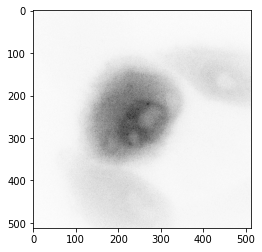

In [ ]:
img = images[0,:,:,0]
f,ax = plt.subplots()
ax.imshow(img, cmap='Greys')

Recall when we plotted the histogram of the intensity pixels to get a sense of the distribution of pixel intensities throughout the image:



Text(0, 0.5, '# of pixels')

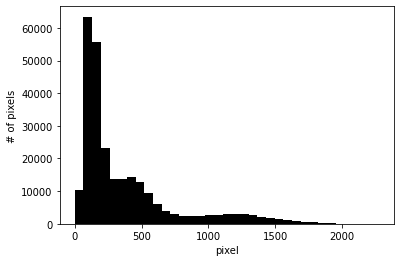

In [ ]:
f, ax = plt.subplots()
_ = ax.hist(img.ravel(),color='k',bins=35)
ax.set_xlabel('pixel')
ax.set_ylabel('# of pixels')

Based on this image, we can could guess a threshold of pixel intensities that are "cells" vs "not cells". What do you think would make a good threshold?

_Modify the cell below and try different thresholds_


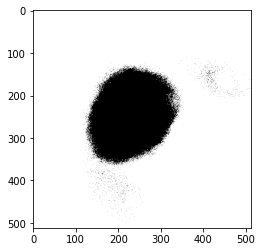

In [ ]:
threshold = 700
mask_image = np.zeros(img.shape)
mask_image[img>threshold] = 255
f,ax = plt.subplots()
ax.imshow(mask_image, cmap='Greys')

This mask image is useful, especially considering we simply took all of the pixels with a value bigger than `threshold`. 

However, we know that the outside ought to be more smooth. Let's try applying a Gaussian filter to smooth out the mask image.


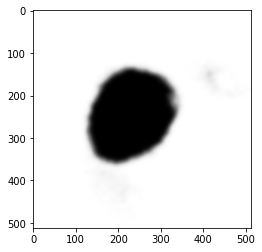

In [ ]:
from skimage.morphology import binary_dilation, watershed
from skimage.filters import gaussian
new_mask = gaussian(mask_image, sigma=5)
f,ax = plt.subplots()
ax.imshow(new_mask, cmap='Greys')

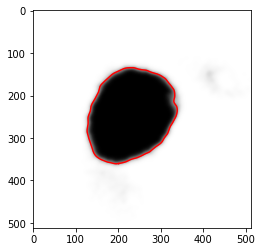

In [ ]:
from skimage import measure
f,ax = plt.subplots()
contours = measure.find_contours(new_mask, level=125 ) # level is half of 255 (ish). What happens if we change it?
ax.imshow(new_mask, cmap='Greys')
for contour in contours:
  ax.plot(contour[:,1],contour[:,0],color='r')

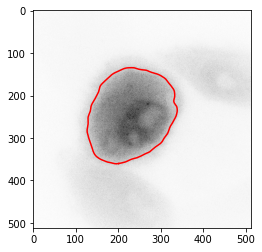

In [ ]:
img = images[0,:,:,0]
f,ax = plt.subplots()
ax.imshow(img, cmap='Greys')
for contour in contours:
  ax.plot(contour[:,1],contour[:,0],'r')

So far so good. By setting `threshold=700` we were able to find the "main" cell in the image. But what happens when we want to get all three? Let's start by lowering the threshold to 200 and running the code. 

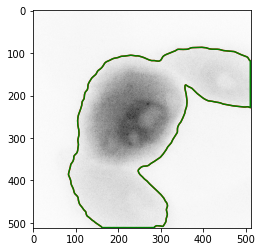

In [ ]:
threshold = 300
mask_image = np.zeros(img.shape)
mask_image[img>threshold] = 255
new_mask = gaussian(mask_image, sigma=4)
contours = measure.find_contours(new_mask, level=125, fully_connected='high')
img = images[0,:,:,0]
f,ax = plt.subplots()
ax.imshow(img, cmap='Greys')
contours_connected = np.vstack((contours))
for contour in contours:
  ax.plot(contour[:,1],contour[:,0],'r')

contours_connected = np.vstack((contours_connected[-1,:],contours_connected))
ax.plot(contours_connected[:,1],contours_connected[:,0],'g')

_it looks like a crab_ 


In the cell below, we will try to take the connected image below and use a [watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing) to break it into 3 distinct cells. 

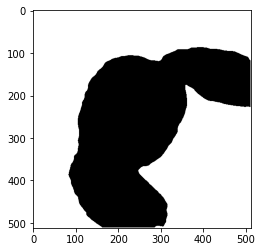

In [ ]:
# make a new mask
from skimage.draw import polygon
watershed_start = np.zeros(img.shape)
rr, cc = polygon(contours_connected[:,0], contours_connected[:,1])
watershed_start[rr,cc] = 1
f,ax = plt.subplots()
ax.imshow(watershed_start, cmap='Greys')

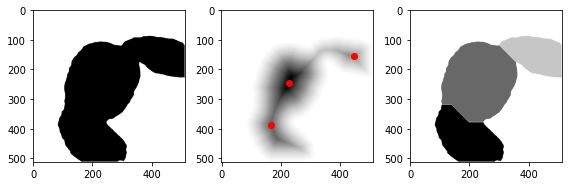

In [ ]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
# apply watershed
distance = ndi.distance_transform_edt(watershed_start) #compute the distance image
coords = peak_local_max(distance, min_distance=50, labels=watershed_start) #use the distance image to find local maxima
_,inds = np.unique(distance[coords[:,0],coords[:,1]],return_index=True) #make sure they are unique
coords = coords[inds,:]
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True # make an image with 1's where local maxima are
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=watershed_start, watershed_line=True) # perform watershed
f,ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(watershed_start, cmap='Greys')
ax[1].imshow(distance, cmap='Greys')
ax[1].scatter(coords[:,1],coords[:,0],c='r')
ax[2].imshow(labels, cmap='Greys')
f.tight_layout() 

# Using CellPose



In [ ]:
%%capture
!pip install cellpose
from cellpose import models
from cellpose import plot

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


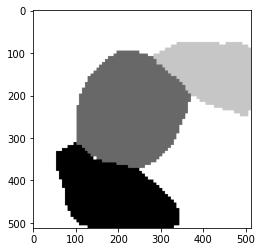

In [ ]:
# RUN CELLPOSE
use_GPU = models.use_gpu()

# DEFINE CELLPOSE MODEL
model = models.Cellpose(gpu=use_GPU, model_type='cyto') # model_type='cyto' or model_type='nuclei'

# Running the models
masks, flows, styles, diams = model.eval(img, diameter=200, flow_threshold=None, channels=[0,0])

plt.imshow(masks,cmap='Greys')
plt.show()

##Segment yeast brightfield images using U-Net



In [ ]:
%%capture
%cd gdrive/MyDrive/
! git clone https://gitlab.inria.fr/InBio/Public/micromator.git
! pip install pims
! pip install trackpy
%cd micromator

In [ ]:
from micromator.segmator import seg_mator
from skimage import io

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2056192/45929032 bytes (4.5%)5537792/45929032 bytes (12.1%)9248768/45929032 bytes (20.1%)12632064/45929032 bytes (27.5%)16506880/45929032 bytes (35.9%)20463616/45929032 bytes (44.6%)24289280/45929032 bytes (52.9%)28114944/45929032 bytes (61.2%)32071680/45929032 bytes (69.8%)35676160/45929032 bytes (77.7%)39403520/45929032 bytes (85.8%)43286528/45929032 bytes (94.2%)

/content/micromator/segmator/data.py:18: UserWarning: Could not load elastic deformations module.
  warnings.warn("Could not load elastic deformations module.")


In [ ]:
# yeast_image = sk.io.imread('../drive/MyDrive/binned_img_51_BF.tif')

urls = ['https://github.com/MunskyGroup/uqbio2021/raw/main/module_1/images/binned_img_65_BF.tif']
print('Downloading file...')
urllib.request.urlretrieve(urls[0],'./binned_img_65_BF.tif')


('./binned_img_65_BF.tif', <http.client.HTTPMessage at 0x7f44a4f58f10>)

In [ ]:
urls = ['https://github.com/MunskyGroup/uqbio2021/raw/main/module_1/images/binned_img_65_RHOD-DIRECT.tif']
print('Downloading file...')
urllib.request.urlretrieve(urls[0],'./binned_img_65_RHOD-DIRECT.tif')

('./binned_img_65_RHOD-DIRECT.tif',
 <http.client.HTTPMessage at 0x7f4148790150>)

In [ ]:
yeast_image = io.imread('./binned_img_65_BF.tif')

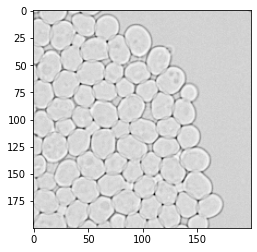

In [ ]:
f, ax = plt.subplots() 
ax.imshow(yeast_image[600:800,50:250], cmap='Greys')

In [ ]:
sm = seg_mator.SegMator('', '', 'segmator/models/unet_yeast_seg_new_v3.hdf5', '.',input_size=(1024,1024,1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
image,mask, contours = sm.segment_single_frame(yeast_image, target_size=(1024,1024))

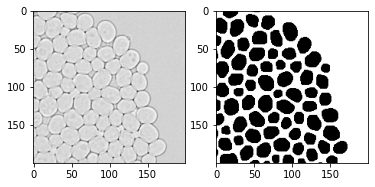

In [ ]:
f,ax = plt.subplots(1,2)
ax[0].imshow(image[600:800,50:250],cmap='Greys')
ax[1].imshow(mask[600:800,50:250],cmap='Greys')

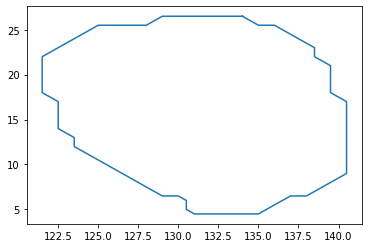

In [ ]:
f,ax = plt.subplots()
ax.plot(contours[5][:,1],contours[5][:,0])



321.0


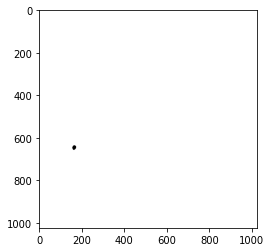

In [ ]:
contour = contours[300]
single_cell_mask = np.zeros(image.shape)
rr, cc = polygon(contour[:,0], contour[:,1])
single_cell_mask[rr,cc] = 1
f,ax = plt.subplots()
ax.imshow(single_cell_mask,cmap='Greys')
cell_size = single_cell_mask.sum()
print(cell_size)

(50.0, 250.0)

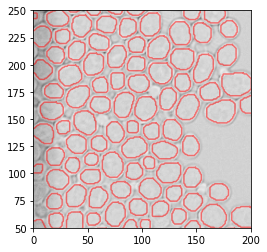

In [ ]:
f,ax = plt.subplots()
ax.imshow(image, cmap='Greys')
for contour in contours:
  ax.plot(contour[:,1],contour[:,0],'r',alpha=.5)

ax.set_xlim([0,200])
ax.set_ylim([50,250])

In [ ]:
# make a histogram of cell sizes within the image.
def get_cell_size(contour, image):
  '''
  '''
  single_cell_mask = np.zeros(image.shape)
  rr, cc = polygon(contour[:,0], contour[:,1])
  single_cell_mask[rr,cc] = 1
  cell_size = single_cell_mask.sum()
  return cell_size

all_cell_sizes = []
for contour in contours:
  all_cell_sizes.append(get_cell_size(contour, image))




Text(0, 0.5, '# of cells')

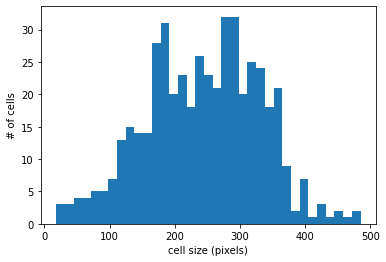

In [ ]:
_ = plt.hist(all_cell_sizes, bins=35)
plt.xlabel('cell size (pixels)')
plt.ylabel('# of cells')

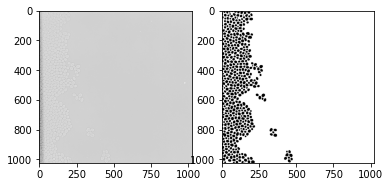

In [ ]:
f,ax = plt.subplots(1,2)
ax[0].imshow(image,cmap='Greys')
ax[1].imshow(mask,cmap='Greys')

In [ ]:
fluor_image = io.imread('./binned_img_65_RHOD-DIRECT.tif')


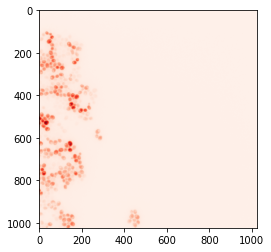

In [ ]:
plt.imshow(fluor_image, cmap='Reds')

# References

Image downloaded from https://figshare.com from publication: "Forero-Quintero, Linda, William Raymond, Tetsuya Handa, Matthew Saxton, Tatsuya Morisaki, Hiroshi Kimura, Edouard Bertrand, Brian Munsky, and Timothy Stasevich. "Live-cell imaging reveals the spatiotemporal organization of endogenous RNA polymerase II phosphorylation at a single gene." (2020)."

"Fox, Z.R., Fletcher, S., Fraisse, A., Aditya, C., Sosa-Carrillo, S., Gilles, S., Bertaux, F., Ruess, J. and Batt, G., 2021. MicroMator: Open and Flexible Software for Reactive Microscopy. bioRxiv. (2021)"